## Importing the necessary libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sms-spam-collection-a-more-diverse-dataset/train.csv


In [2]:
!pip install wget

  Preparing metadata (setup.py) ... - done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=4974772567af9aebe3b5db1ced8c8588fbc6188e25eec7d03079cd8549ca7015
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [3]:
!pip install transformers

In [4]:
import wget
wget.download("https://raw.githubusercontent.com/yogawicaksana/helper_prabowo/main/helper_prabowo_ml.py",out="helper_prabowo_ml.py")

'helper_prabowo_ml.py'

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from helper_prabowo_ml import clean_html, remove_links, remove_special_characters, removeStopWords, remove_, remove_digits, lower, email_address, non_ascii, punct, hashtags
from wordcloud import WordCloud
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.metrics import confusion_matrix, classification_report

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
plt.rcParams['figure.figsize'] = (12,8)

## Loading the SMS spam collection dataset

In [7]:
df = pd.read_csv("/kaggle/input/sms-spam-collection-a-more-diverse-dataset/train.csv")
df.head()

,sms,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...\n,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


## Feature Engineering

In [8]:
df.shape

(5574, 2)

In [9]:
df.isna().sum()

sms      0
label    0
dtype: int64

In [10]:
df.duplicated().sum()

403

In [11]:
df = df.drop_duplicates()
df.shape

(5171, 2)

In [12]:
df.sms.str.isspace().sum()

0

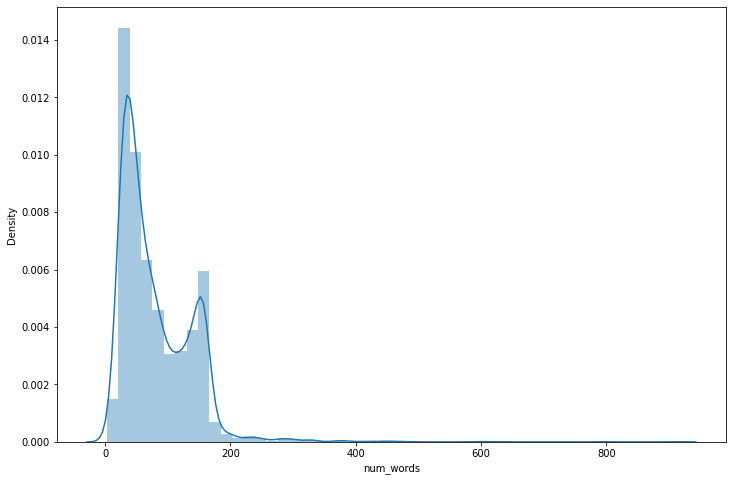

In [13]:
df['num_words'] = df.sms.apply(len)
sns.distplot(df.num_words);

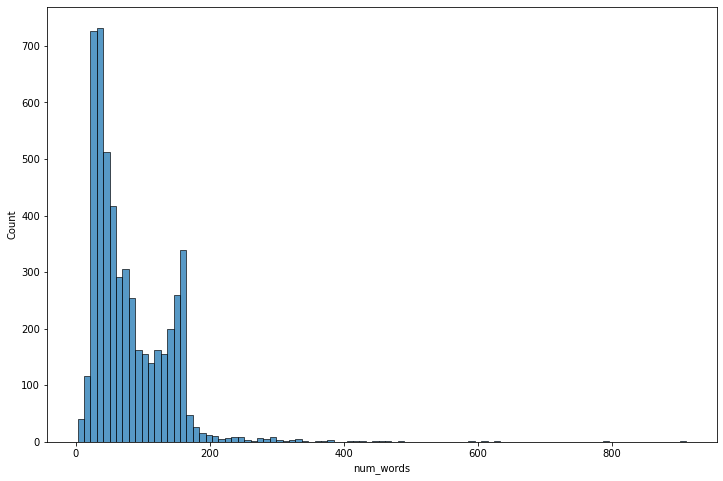

In [14]:
sns.histplot(df.num_words);

In [15]:
print("Average number of words in an SMS:",df.num_words.mean())

Average number of words in an SMS: 80.33243086443628


In [16]:
df.num_words.describe()

count    5171.000000
mean       80.332431
std        58.333188
min         3.000000
25%        37.000000
50%        62.000000
75%       120.000000
max       911.000000
Name: num_words, dtype: float64

In [17]:
max_len = 80

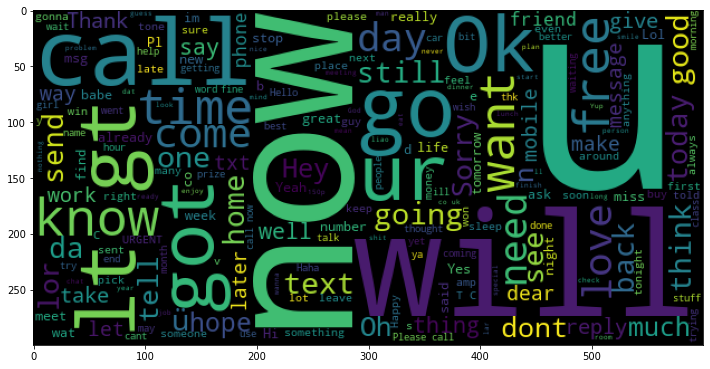

In [18]:
wc = WordCloud(width=600,height=300,random_state=101).generate(' '.join(df.sms))
plt.imshow(wc);

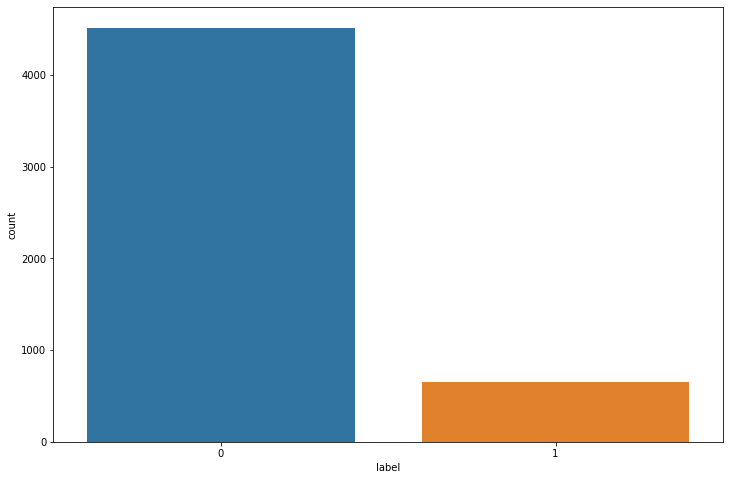

In [19]:
sns.countplot(df.label);

The dataset is highly imbalanced as clearly indicated by the above countplot. The total count of "spam" SMSs is very less as compared to that of legitimate and valid SMSs.

## Text Preprocessing

In [20]:
def text_preprocess(data,col):
    data[col] = data[col].apply(func=clean_html)
    data[col] = data[col].apply(func=remove_)
    data[col] = data[col].apply(func=removeStopWords)
    data[col] = data[col].apply(func=remove_digits)
    data[col] = data[col].apply(func=remove_links)
    data[col] = data[col].apply(func=remove_special_characters)
    data[col] = data[col].apply(func=punct)
    data[col] = data[col].apply(func=non_ascii)
    data[col] = data[col].apply(func=email_address)
    data[col] = data[col].apply(func=lower)
    return data

In [21]:
preprocessed_df = text_preprocess(df,'sms')
preprocessed_df.head()

,sms,label,num_words
0,go jurong point crazy available bugis n great ...,0,112
1,ok lar joking wif u oni,0,30
2,free entry wkly comp win fa cup final tkts st ...,1,156
3,u dun say early hor u c already say,0,50
4,nah think goes usf lives around though,0,62


## Splitting the dataset into training and test sets

In [22]:
 train_df, test_df = train_test_split(preprocessed_df,test_size=0.3,random_state=42,shuffle=True,stratify=preprocessed_df.label)

## Loading the pretrained Tokenizer class and the pretrained ROBERTA-BASE transformer model

In [23]:
tokenizer = AutoTokenizer.from_pretrained("mariagrandury/roberta-base-finetuned-sms-spam-detection")
roberta = TFAutoModelForSequenceClassification.from_pretrained("mariagrandury/roberta-base-finetuned-sms-spam-detection",from_pt=True)

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/780k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.01M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/735 [00:00<?, ?B/s]

2022-12-14 21:28:50.580842: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 21:28:50.581769: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 21:28:50.582773: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 21:28:50.583539: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 21:28:50.584301: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Downloading:   0%|          | 0.00/476M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


## Performing text tokenization

In [24]:
X_train = tokenizer(text=train_df.sms.tolist(),
                   max_length=max_len,
                   padding=True,
                   truncation=True,
                   add_special_tokens=True,
                   return_tensors="tf",
                   return_attention_mask=True,
                   return_token_type_ids=False,
                   verbose=True)
X_test = tokenizer(text=test_df.sms.tolist(),
                  max_length=max_len,
                  padding=True,
                  truncation=True,
                  add_special_tokens=True,
                  return_tensors="tf",
                  return_attention_mask=True,
                  return_token_type_ids=False,
                  verbose=True)

## Fine-tuning the ROBERTA transformer model architecture

In [25]:
input_ids = Input(shape=(max_len,),dtype=tf.int32,name='input_ids')
attention_mask = Input(shape=(max_len,),dtype=tf.int32,name='attention_mask')

In [26]:
embeddings = roberta(input_ids,attention_mask=attention_mask)[0] # 0 --> final hidden state, 1 --> pooling output
output = Flatten()(embeddings)
output = Dense(units=1024,activation='relu')(output)
output = Dropout(0.3)(output)
output = Dense(units=512,activation='relu')(output)
output = Dropout(0.2)(output)
output = Dense(units=256,activation='relu')(output)
output = Dropout(0.1)(output)
output = Dense(units=128,activation='relu')(output)
output = Dense(units=2,activation='sigmoid')(output)

model = Model(inputs=[input_ids,attention_mask],outputs=output)
model.layers[2].trainable = True

## Visualizing the model architecture

In [27]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 80)]         0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 80)]         0                                            
__________________________________________________________________________________________________
tf_roberta_for_sequence_classif TFSequenceClassifier 124647170   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
flatten (Flatten)               (None, 2)            0           tf_roberta_for_sequence_class

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


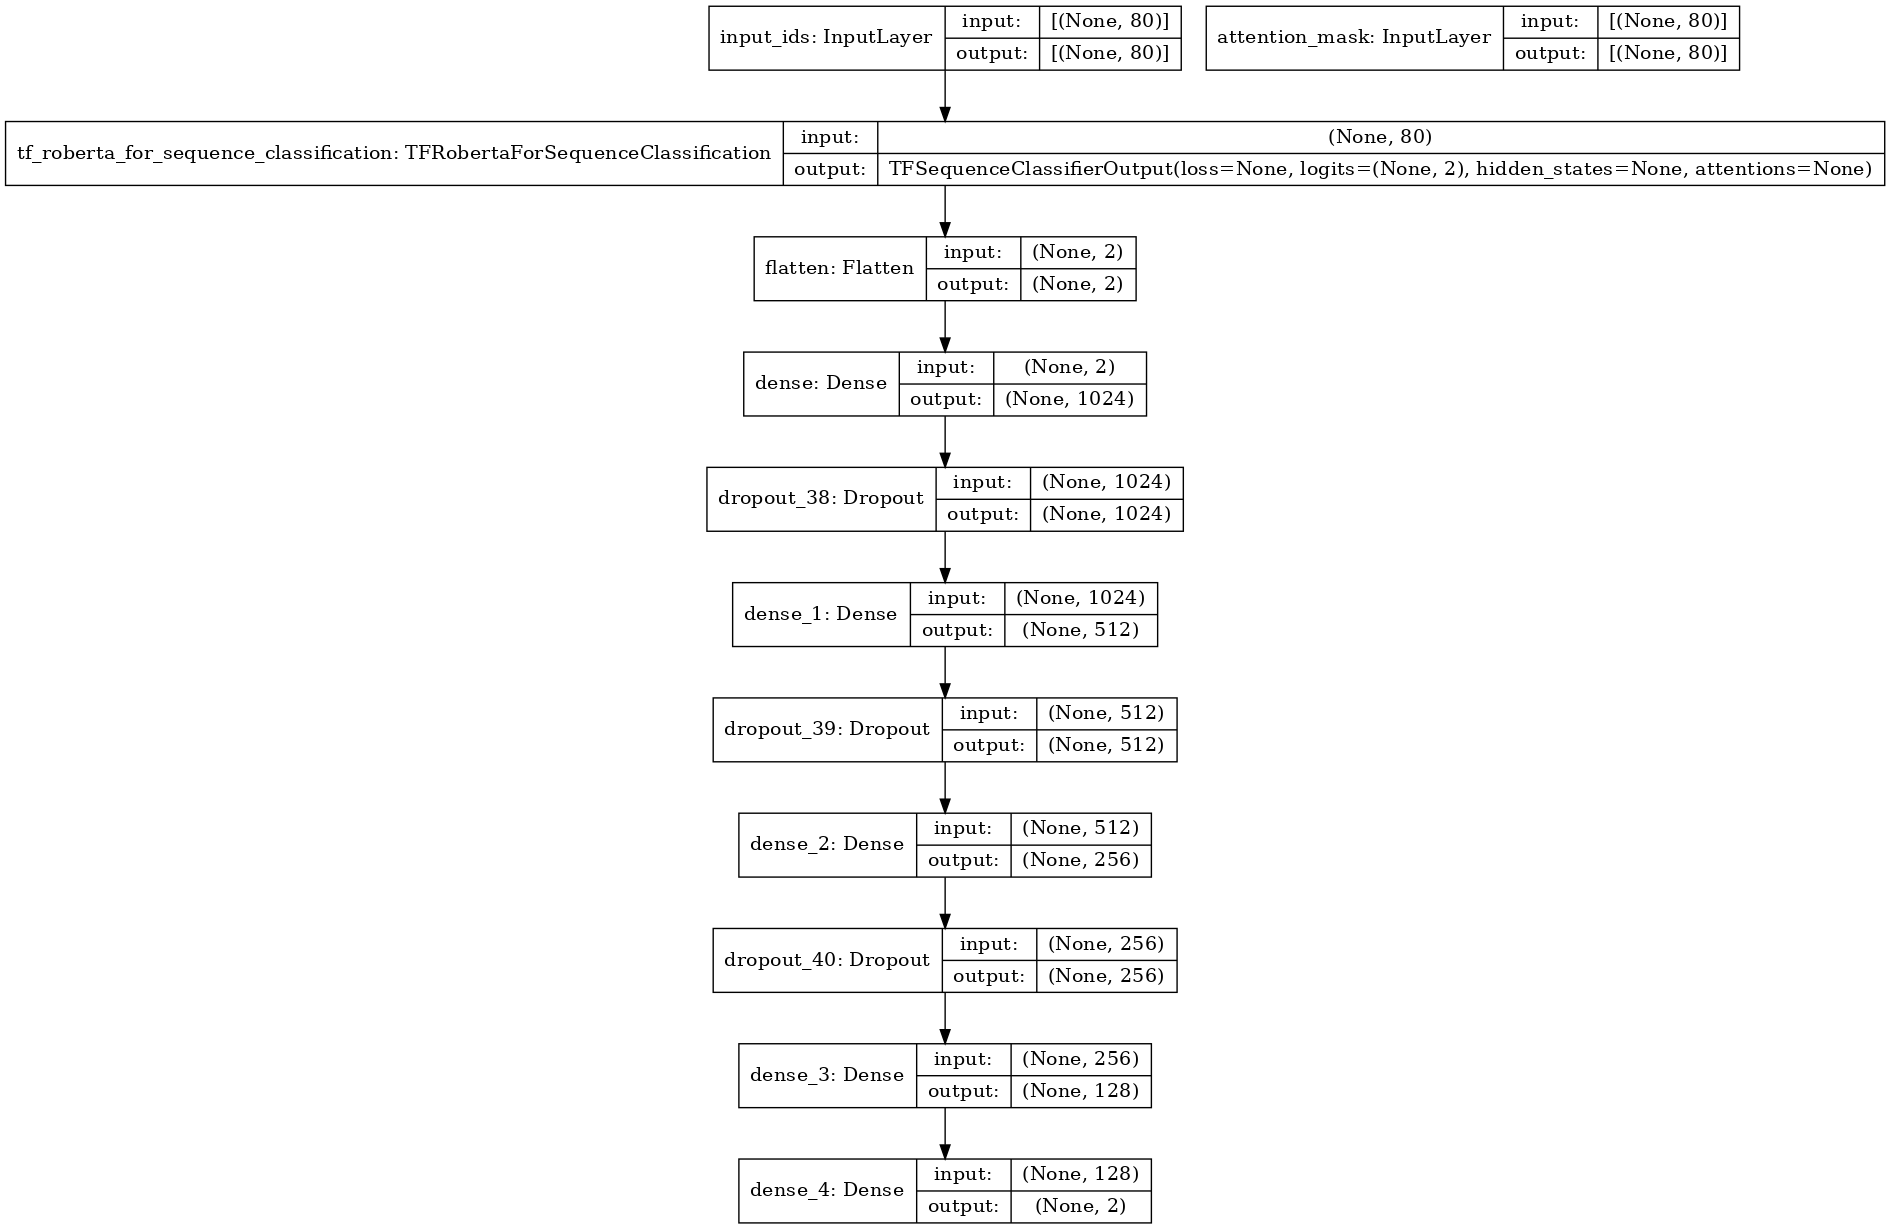

In [28]:
plot_model(model,'ROBERTA-BASE-FINETUNED-SMS-SPAM-DETECTION.png',dpi=100,show_shapes=True)

## Compiling the model

In [29]:
optimizer = Adam(learning_rate=5e-5,epsilon=2e-8,decay=0.01,clipnorm=1.0)
loss = BinaryCrossentropy(from_logits=True)
metrics = BinaryAccuracy('balanced_accuracy')
model.compile(loss=loss,optimizer=optimizer,metrics=metrics)

## Training the fine-tuned ROBERTA transformer model

In [30]:
es = EarlyStopping(monitor='val_balanced_accuracy',patience=20,verbose=1,mode='max')
mc = ModelCheckpoint(filepath='checkpoint',monitor='val_balanced_accuracy',mode='max',save_best_only=True,verbose=1)

r = model.fit(x={'input_ids': X_train['input_ids'], 'attention_mask': X_train['attention_mask']},
              y=to_categorical(train_df.label),
              epochs=50,
              batch_size=32,
              callbacks=[es,mc],
              validation_data=({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},to_categorical(test_df.label))
             )

2022-12-14 21:29:25.686808: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
114/114 [==============================] - 84s 563ms/step - loss: 0.2421 - balanced_accuracy: 0.9254 - val_loss: 0.0896 - val_balanced_accuracy: 0.9813

Epoch 00001: val_balanced_accuracy improved from -inf to 0.98131, saving model to checkpoint


2022-12-14 21:31:04.031027: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/50
114/114 [==============================] - 65s 571ms/step - loss: 0.0989 - balanced_accuracy: 0.9787 - val_loss: 0.0755 - val_balanced_accuracy: 0.9787

Epoch 00002: val_balanced_accuracy did not improve from 0.98131
Epoch 3/50
114/114 [==============================] - 65s 572ms/step - loss: 0.0532 - balanced_accuracy: 0.9878 - val_loss: 0.0456 - val_balanced_accuracy: 0.9858

Epoch 00003: val_balanced_accuracy improved from 0.98131 to 0.98582, saving model to checkpoint
Epoch 4/50
114/114 [==============================] - 66s 576ms/step - loss: 0.0392 - balanced_accuracy: 0.9914 - val_loss: 0.0332 - val_balanced_accuracy: 0.9897

Epoch 00004: val_balanced_accuracy improved from 0.98582 to 0.98969, saving model to checkpoint
Epoch 5/50
114/114 [==============================] - 66s 575ms/step - loss: 0.0248 - balanced_accuracy: 0.9947 - val_loss: 0.0399 - val_balanced_accuracy: 0.9890

Epoch 00005: val_balanced_accuracy did not improve from 0.98969
Epoch 6/50
114/114 [====

## Analyzing the overall performance of the fine-tuned ROBERTA transformer model

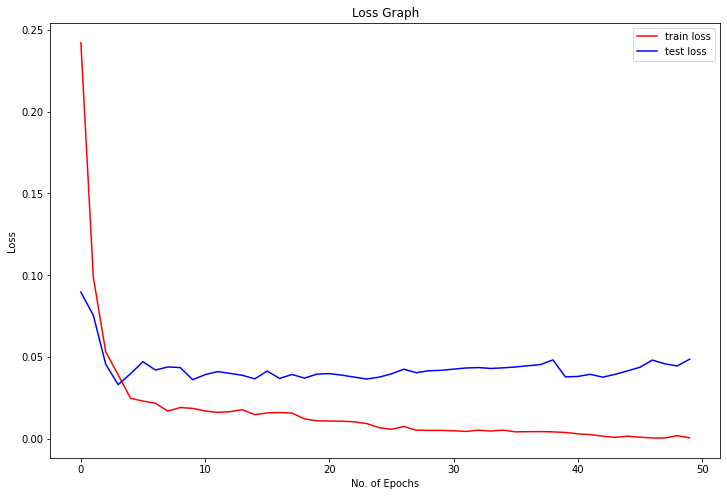

In [31]:
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='test loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

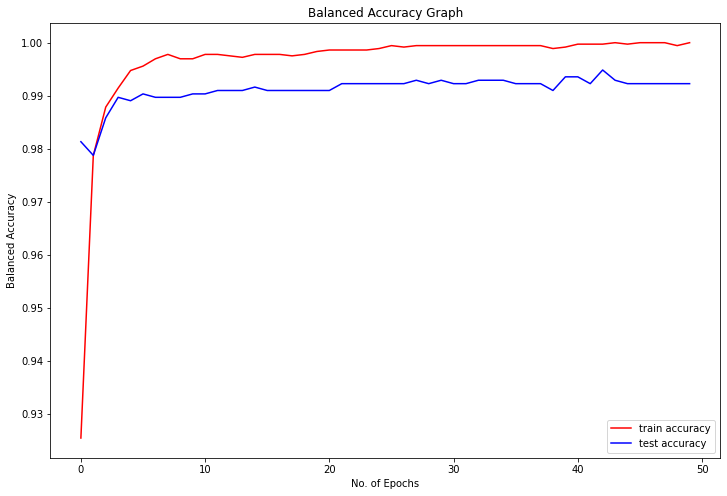

In [32]:
plt.plot(r.history['balanced_accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_balanced_accuracy'],'b',label='test accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Balanced Accuracy')
plt.title('Balanced Accuracy Graph')
plt.legend();

## Saving the model

In [33]:
model.save('sms_spam_detector.h5')

## Model Evaluation

In [34]:
loss, acc = model.evaluate({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},to_categorical(test_df.label))
print("Test Binary Crossentropy Loss:", loss)
print("Test Binary Accuracy:", acc)

49/49 [==============================] - 8s 165ms/step - loss: 0.0487 - balanced_accuracy: 0.9923
Test Binary Crossentropy Loss: 0.04869041591882706
Test Binary Accuracy: 0.9922680258750916


In [35]:
test_predictions = model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})
test_predictions = np.argmax(test_predictions,axis=1)
print("Confusion Matrix:")
print(confusion_matrix(test_df.label,test_predictions))
print("Classification Report:")
print(classification_report(test_df.label,test_predictions))

Confusion Matrix:
[[1352    4]
 [   8  188]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1356
           1       0.98      0.96      0.97       196

    accuracy                           0.99      1552
   macro avg       0.99      0.98      0.98      1552
weighted avg       0.99      0.99      0.99      1552



Bravo! The fine-tuned ROBERTA-BASE SMS Spam detection transformer model has produced an outstanding balanced accuracy of more than 99% on the test set. 

Do upvote if you like my work!